In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
def f(w0, w1, x):
    return x*w1+w0

def plot_fit(ws, height, weight):
    xmin = min(height)
    xmax = max(height)
    w1 = ws[len(ws)-1][1]
    w0 = ws[len(ws)-1][0]
    print('w0', w0, 'w1', w1, 'pts', ([0.0,2.0], [w0, 2.0*w1+w0]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.scatter(height, weight, s = 40, c = 'b', marker = '+')
    ax1.plot([xmin,xmax], [f(w0, w1, xmin), f(w0, w1, xmax)], color = 'red', linestyle = 'solid')
    plt.show()

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [25]:
def compute_error(y, tx, w):
    print("y", y.shape, "tx", tx.shape, "w", w.shape)
    return y - (tx @ w)

def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)

def compute_loss(y, tx, w, cost_fn = calculate_mse):
    # w = [w0,w1]
    error = compute_error(y, tx, w)
    return cost_fn(error)

# 2 Grid Search

Fill in the function `grid_search()` below:

In [6]:
def _arrayMap(f, *x):
    return np.array(list(map(f,*x)))

def with_indices(p, q, function):
    rows, cols = np.indices((p.shape[0], q.shape[0]))
    return _arrayMap(function, p[rows.ravel()], q[cols.ravel()])

def grid_search(y, tx, w0, w1):
    lossFn = lambda _w0, _w1: compute_loss(y, tx, [_w0, _w1])
    # losses = np.zeros((len(w0), len(w1)))
    losses = with_indices(w0, w1, lossFn)
    return np.reshape(losses, (w0.shape[0], w1.shape[0]))

Let us play with the grid search demo now!

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

def grid_generation(num_intervals = 10):
    print('num_intervals', num_intervals)
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals)

    # Start the grid search
    start_time = datetime.datetime.now()
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()

    # Print the results
    print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

    # Plot the results
    fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
    fig.set_size_inches(10.0,6.0)
    fig.savefig("grid_plot")  # Optional saving
    return grid_w0, grid_w1, grid_losses

num_intervals 10
Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.012 seconds


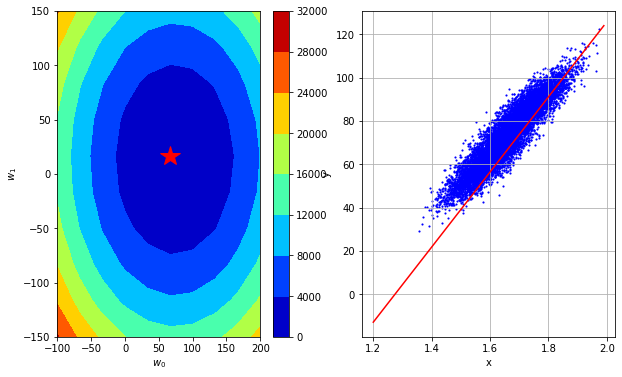

In [8]:
grid_w0, grid_w1, grid_losses = grid_generation()

num_intervals 50
Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.128 seconds


(array([-100.        ,  -93.87755102,  -87.75510204,  -81.63265306,
         -75.51020408,  -69.3877551 ,  -63.26530612,  -57.14285714,
         -51.02040816,  -44.89795918,  -38.7755102 ,  -32.65306122,
         -26.53061224,  -20.40816327,  -14.28571429,   -8.16326531,
          -2.04081633,    4.08163265,   10.20408163,   16.32653061,
          22.44897959,   28.57142857,   34.69387755,   40.81632653,
          46.93877551,   53.06122449,   59.18367347,   65.30612245,
          71.42857143,   77.55102041,   83.67346939,   89.79591837,
          95.91836735,  102.04081633,  108.16326531,  114.28571429,
         120.40816327,  126.53061224,  132.65306122,  138.7755102 ,
         144.89795918,  151.02040816,  157.14285714,  163.26530612,
         169.3877551 ,  175.51020408,  181.63265306,  187.75510204,
         193.87755102,  200.        ]),
 array([-150.        , -143.87755102, -137.75510204, -131.63265306,
        -125.51020408, -119.3877551 , -113.26530612, -107.14285714,
        

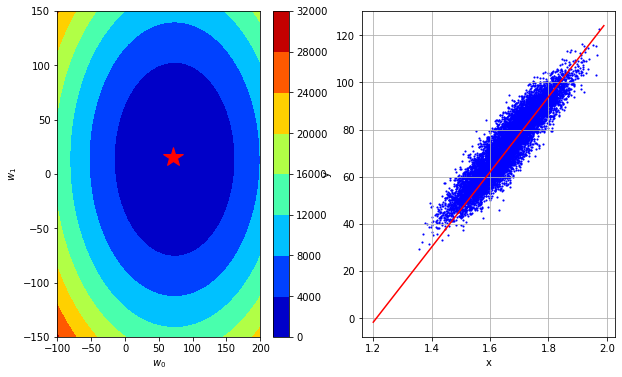

In [9]:
grid_generation(50)
#grid_generation(1000)

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [26]:
def compute_gradient(y, tx, w):
    error = compute_error(y, tx, w)
    print(error.shape)
    return -1/y.shape[0] * tx.T @ error
    
# compute_gradient(y, tx, np.array([1,2]))

Please fill in the functions `gradient_descent` below:

In [27]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, log = False):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        w = w - gamma * gradient
        ws.append(w)
        losses.append(loss)
        if log:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    print("w0={w0}, w1={w1}".format(w0=w[0], w1=w[1]))
    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [29]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma, True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(0/49): loss=2792.2367127591674, w0=51.30574540147361, w1=9.435798704492262
y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(1/49): loss=265.3024621089606, w0=66.69746902191571, w1=12.266538315840004
y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(2/49): loss=37.87837955044127, w0=71.31498610804834, w1=13.11576019924433
y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(3/49): loss=17.41021212017447, w0=72.70024123388814, w1=13.370526764265632
y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(4/49): loss=15.568077051450455, w0=73.11581777164008, w1=13.446956733772023
y (10000,) tx (10000, 2) w (2,)
(10000,)
y (10000,) tx (10000, 2) w (2,)
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
y (10000,

In [34]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

In [35]:
print(compute_gradient(y, tx, np.array([100,20])))
print(compute_gradient(y, tx, np.array([50,10])))

[26.706078    6.52028757]
[-23.293922    -3.47971243]


# 4 Stochastic gradient descent

In [15]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation.It's same as the gradient descent.
    # ***************************************************
    raise NotImplementedError


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma, log = False):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    i = 0
    for mini_y, mini_x in batch_iter(y, tx, batch_size, max_iters):
        gradient = compute_gradient(mini_y, mini_x, w)
        loss = compute_loss(mini_y, mini_x, w)
        w = w - gamma * gradient
        ws.append(w)
        losses.append(loss)
        i = i+1
        if log:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=i, ti=max_iters, l=loss, w0=w[0], w1=w[1]))
    print("w0={w0}, w1={w1}".format(w0=w[0], w1=w[1]))
    return losses, ws

In [16]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 10

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma, True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(1/50): loss=2870.006826282059, w0=52.16681768149735, w1=19.656756100786122
Gradient Descent(2/50): loss=182.41043368426932, w0=64.80353431723971, w1=20.645725977314143
Gradient Descent(3/50): loss=85.15144350058605, w0=69.94504443316367, w1=13.955526548902924
Gradient Descent(4/50): loss=26.43545142998688, w0=74.28876903567118, w1=12.274595298364643
Gradient Descent(5/50): loss=22.839338872777144, w0=76.96830121712178, w1=14.10004432905208
Gradient Descent(6/50): loss=18.44755456551008, w0=73.77160804526602, w1=11.883973760525919
Gradient Descent(7/50): loss=15.180610390849319, w0=74.76650541848349, w1=12.470441027426961
Gradient Descent(8/50): loss=19.83723993450565, w0=74.29585097921188, w1=11.770225733322018
Gradient Descent(9/50): loss=14.301603113021011, w0=76.2418481667776, w1=13.731871996072822
Gradient Descent(10/50): loss=17.27771192493913, w0=74.6481683043216, w1=12.03240605730107
Gradient Descent(11/50): loss=27.404880217452195, w0=72.14841680773146, w1=13.5

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

w0 75.61813609268346 w1 14.485928166967204 pts ([0.0, 2.0], [75.61813609268346, 104.58999242661787])


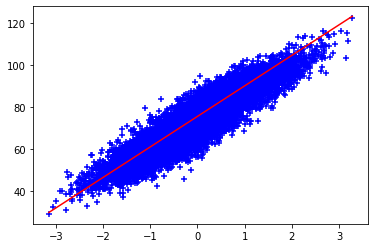

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))
plot_fit(sgd_ws, x, y)

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

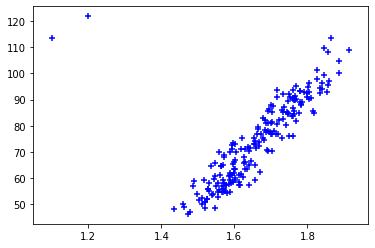

w0=74.06780585492636, w1=11.034894865989102
w0 74.06780585492636 w1 11.034894865989102 pts ([0.0, 2.0], [74.06780585492636, 96.13759558690457])


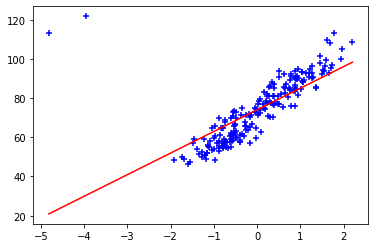

w0=139.8737071159662, w1=91.82989874802212
w0 139.8737071159662 w1 91.82989874802212 pts ([0.0, 2.0], [139.8737071159662, 323.53350461201046])


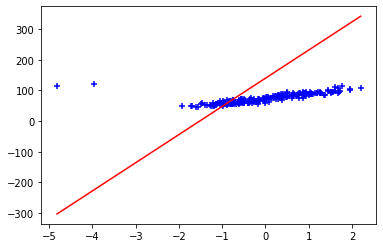

In [18]:
gamma = 0.7
max_iters = 50
batch_size = 1
initial_w = np.array([0,0])
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(height, weight, s = 40, c = 'b', marker = '+')
plt.show()
losses, ws = gradient_descent(y, tx, initial_w, max_iters, gamma)
plot_fit(ws, x, y)
losses, ws = stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma)
plot_fit(ws, x, y)



### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [51]:
import random as rd
    
def compute_subgradient(y, tx, w):
    error = compute_error(y, tx, w)
    e_shape = error.shape
    #v = _arrayMap(_error_sign, error)
    v = np.sign(error)
    gradient = -1/y.shape[0] * tx.T @ v
    return gradient

def calculate_mae(e):
    return np.mean(abs(e))

In [52]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma, log = False):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_subgradient(y, tx, w)
        loss = compute_loss(y, tx, w, calculate_mae)
        w = w - gamma * gradient
        ws.append(w)
        losses.append(loss)
        if log:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    print("w0={w0}, w1={w1}".format(w0=w[0], w1=w[1]))
    return losses, ws

w0=73.23847999999704, w1=13.524381898258982
w0 73.23847999999704 w1 13.524381898258982 pts ([0.0, 2.0], [73.23847999999704, 100.287243796515])


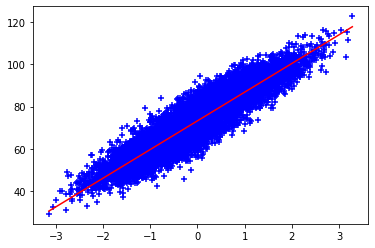

In [53]:
gamma = 0.7
max_iters = 200
initial_w = np.array([0,0])
losses, ws = subgradient_descent(y, tx, initial_w, max_iters, gamma)
plot_fit(ws, x, y)